In [1]:
import sys
import stmpy
import numpy as np
import cancelv3 as cancel
from decimal import *
import matplotlib.pyplot as plt
from sklearn.externals import joblib
import pandas as pd
import scipy.fftpack as fftp
import os
from scipy import signal
import scipy
import matplotlib.pyplot as plt
import time
import gc
%pylab inline
plt.style.use('classic')

C:\Users\jgoet\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


In [2]:
folder_loc = '2020-03-13/Chirp Calibration v2/'
file_loc = '2020-03-13-18-01_chirp2_cal001.dat'
dat = np.loadtxt(folder_loc+file_loc,skiprows=76)

for filename in os.listdir(folder_loc):
    if filename == file_loc:
        pass
    try:
        tempdata = np.loadtxt(folder_loc+filename, skiprows=76)
        dat = np.concatenate((dat,tempdata))
        print(filename,end='\r')
    except:
        print('ERROR: ',filename)

In [3]:
fs = 10000
# start = int(38.65*fs)
# end = int(2039.7*fs)
geo = dat[:,0]
chirp = dat[:,1]
tip = dat[:,2]
# cur = dat[start:end,0]
# geo = dat[start:end,1]
# chirp = dat[start:end,2]
# geo_in = dat[start:end,3]
# tip = dat[start:end,6]
# LIY = dat[start:end,8]

t = linspace(0,len(chirp)/10000,len(chirp))

C:\Users\jgoet\Documents\Python Code ES100\stmpy\image.py:258: MatplotlibDeprecationWarning: 
The get_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.get_clim instead.
  low, high = cb.get_clim()


Text(0, 0.5, 'Geophone frequency response (Hz)')

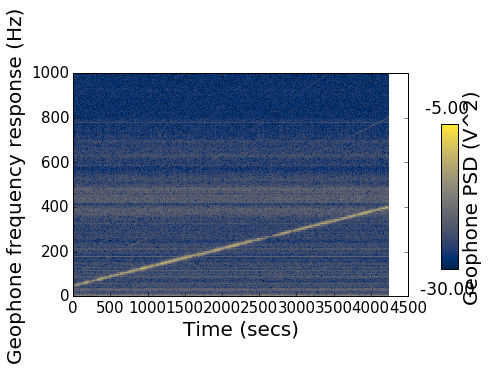

In [4]:
# figure(figsize=[20,30])
fig,ax = subplots(1,1)
figsize(10,8)
fs = 10000
f, t_spt, Sxx = signal.spectrogram(geo, fs,nperseg=10000)
im1 = ax.pcolormesh(t_spt,f,log(Sxx),cmap=stmpy.cm.cividis, vmin=-30,vmax=-5,rasterized=True)
# im = imshow(flip(log(Sxx),axis=0), cmap=stmpy.cm.cividis, aspect=1, clim=(-30,-5),rasterized=True)
cb = stmpy.image.add_cbar(thickness='5%',length='65%',hPos=0.98)
ax.set_ylim(0,1000)
cb.set_label('Geophone PSD (V^2)', color='k',size = 20)
# plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color='r')
# im.axes.set_xticklabels(['1','0','10','20','30','40','50'],color='w')
# im.axes.set_yticklabels(['0','50','40','30','20','10'],color='w')
im1.axes.tick_params(labelsize=15,color='k')
ax.set_xlabel('Time (secs)',size=20,color='k')
ax.set_ylabel('Geophone frequency response (Hz)',size=20,color='k')
# savefig('2020-03-13 Geophone Spectrogram',transparent= True)

(5001,) (5001, 4842)
3500.5


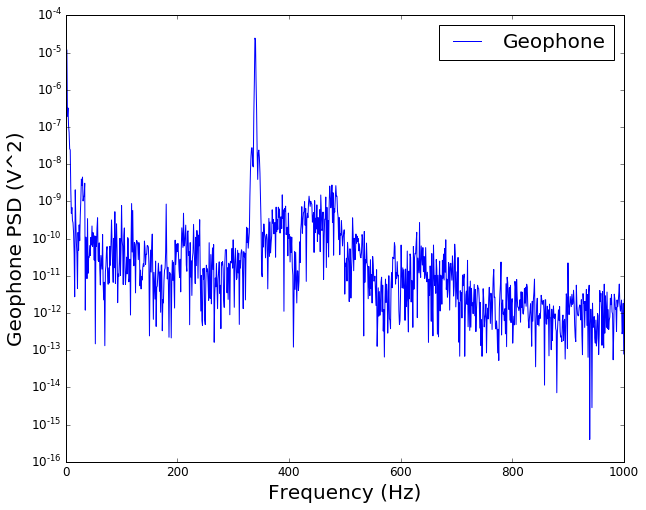

In [5]:
print(shape(f),shape(log(Sxx)))
print(t_spt[4000])

semilogy(f,(Sxx[:,4000]),label="Geophone")
tick_params(labelsize=12)
xlabel('Frequency (Hz)',size=20)
ylabel('Geophone PSD (V^2)',size=20)
legend(loc=0,fontsize=20)
xlim(0,1000)
grid(False)

Text(0, 0.5, 'Frequency Chirp (Hz)')

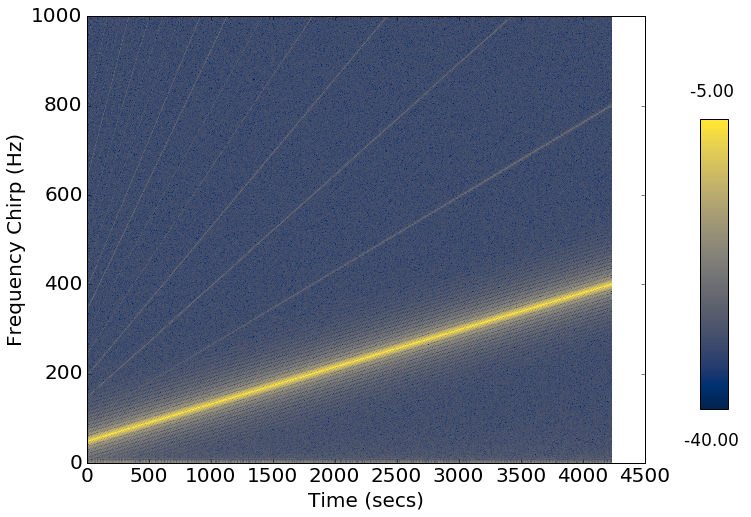

In [6]:
# figure(figsize=[20,30])
fig,ax = subplots(1,1)
figsize(15,10)
fs = 10000
f, t_spt, Sxx = signal.spectrogram(chirp, fs,nperseg=10000)
im1 = ax.pcolormesh(t_spt,f,log(Sxx),cmap=stmpy.cm.cividis, vmin=-40,vmax=-5,rasterized=True)
# im = imshow(flip(log(Sxx),axis=0), cmap=stmpy.cm.cividis, aspect=1, clim=(-30,-5),rasterized=True)
cb = stmpy.image.add_cbar(thickness='5%',length='65%',hPos=0.98)
ax.set_ylim(0,1000)
# cb.set_label('colorbar label', color='w')
# plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color='r')
# im.axes.set_xticklabels(['1','0','10','20','30','40','50'],color='w')
# im.axes.set_yticklabels(['0','50','40','30','20','10'],color='w')
im1.axes.tick_params(labelsize=20)
ax.set_xlabel('Time (secs)',size=20)
ax.set_ylabel('Frequency Chirp (Hz)',size=20)
# savefig('2020-03-13 Chirp Spectrogram',transparent= True)

Text(0, 0.5, 'Driven voltage mag ( )')

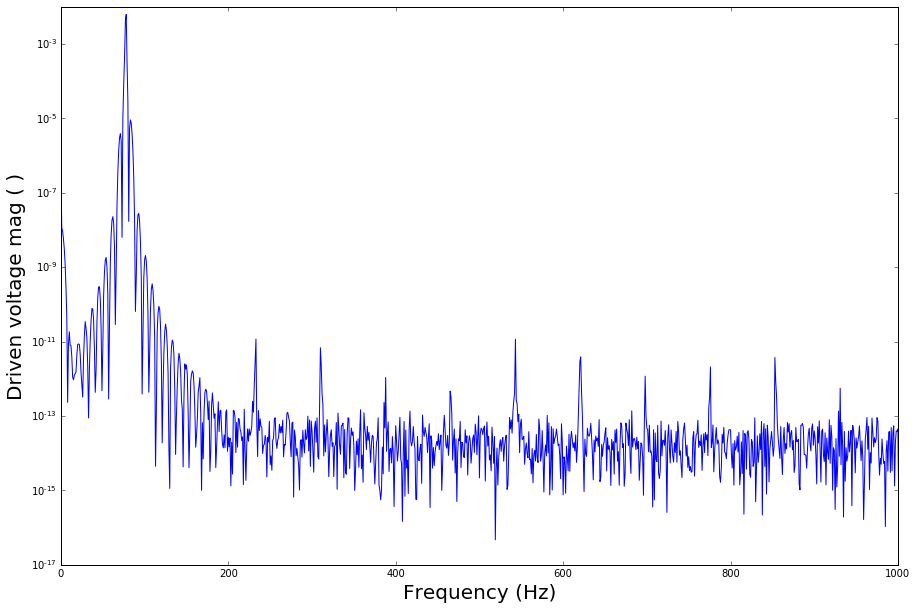

In [7]:
semilogy(f,Sxx[:,400])
xlim(0,1000)
xlabel('Frequency (Hz)',size=20)
ylabel('Driven voltage mag ( )',size=20)

In [8]:
# figsize(15,6)
# plot(t,tip)
# tip_shift = np.copy(tip)
# tip_shift[15559000:] = tip[15559000:]+0.05e-8
# plot(t,tip_shift)
# xlabel('Time (sec)',size=20)
# ylabel('Tip position (nm)',size=20)
# grid(False)
# xlim(1555.75,1556)

In [9]:
print((4228.98-19.055)/35000)

0.1202835714285714


In [10]:
def fit_cancel(array, n=1):
    t=linspace(0,len(array),len(array))
    fit = polyfit(t,array,n)
    corrective = fit[n]*ones(shape(t))
    for j in arange(n):
        corrective += fit[j]*(t**(n-j))
    return array - corrective

def cancel_skips(array, tol):
    data = array[15:]-array[:-15]
    markers = where(abs(data)>=tol)*sign(data)[where(abs(data)>=tol)]
    result = array[0:abs(int(markers[0][0]))]
    counter=markers[0][0]
    gap = 0
    for idx in markers[0]:
        if (counter*idx) < 1:
            result = concatenate((result,array[abs(int(counter)):abs(int(idx))]-gap))
            counter = idx
            gap = 0
        else:
            if markers[0][0] > 0: gap = max(gap,data[abs(int(idx))])
            else: gap = min(gap,data[abs(int(idx))])
    if shape(array) is not shape(result):
        result = concatenate((result,array[abs(int(counter)):]-gap))
    return result

# tip_shift = cancel_skips(tip-mean(tip),0.5e-9)

42371200 42371200 42371200


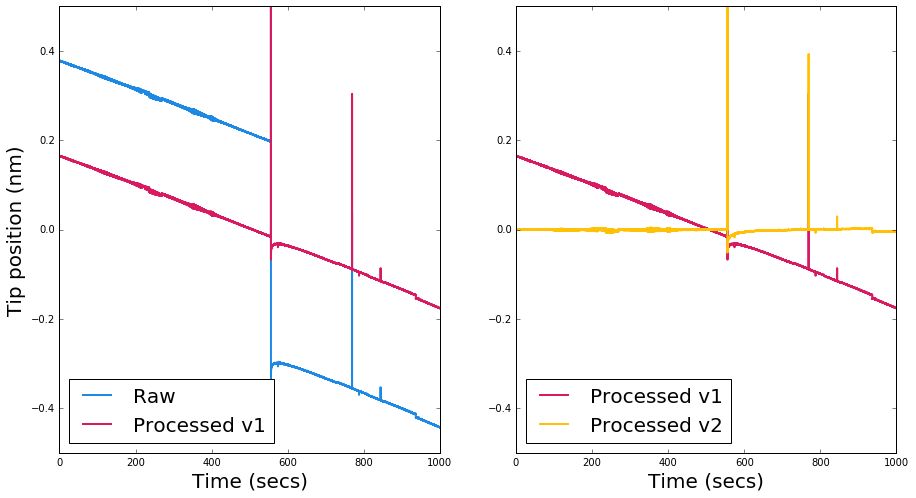

In [11]:
figsize(15,8)
tip_shift = np.copy(tip)-mean(tip)
tip_shift[15559000:] = tip_shift[15559000:]+0.048e-8

# tip_fit = fit_cancel(tip_shift,n=2)
# plot(t,tip)
fig,ax = subplots(1,2)
figsize(15,7)
fit = poly1d(polyfit(t[::200],tip_shift[::200]-mean(tip_shift[::200]),4))
lev = tip_shift-fit(t)-mean(tip_shift-fit(t))
print(len(tip),len(tip_shift),len(lev))
# lev_shift = cancel_skips(lev,0.1e-10)
# fit2 = poly1d(polyfit(t[::400],lev[::400],10))
ax[0].plot(t[10000000:20000000:200]-1000,1e9*(tip[10000000:20000000:200]-mean(tip[10000000:20000000:200])),'#1e88e5',linewidth=2,label='Raw')
# plot(t[::200],fit(t[::200]))
ax[0].plot(t[10000000:20000000:200]-1000,1e9*(tip_shift[10000000:20000000:200]-mean(tip_shift[10000000:20000000:200])),'#d81b60',linewidth=2,label='Processed v1')
ax[1].plot(t[10000000:20000000:200]-1000,1e9*(tip_shift[10000000:20000000:200]-mean(tip_shift[10000000:20000000:200])),'#d81b60',label='Processed v1',linewidth=2)
# plot(t[::200],tip_shift[::200]-fit(t[::200]))
ax[1].plot(t[10000000:20000000:200]-1000,1e9*lev[10000000:20000000:200],'#ffc107',label='Processed v2',linewidth=2)
ax[0].set_xlabel('Time (secs)',size=20)
ax[1].set_xlabel('Time (secs)',size=20)
ax[0].set_ylabel('Tip position (nm)',size=20)
ax[0].legend(loc=3,fontsize=20)
ax[1].legend(loc=3,fontsize=20)
ax[1].set_ylim(-0.5,0.5)
ax[0].set_ylim(-0.5,0.5)
# plot(t[::200],lev_shift[::200])
# plot(t[::200],fit2(t[::200]))
# ylim(-0.1e-9,0.1e-9)
grid(False)
# %reset_selective -f tip_shift
# tip_temp = tip-mean(tip)
# tip_temp[18697800:] = 2e-10+tip_temp[18697800:]
# tip_fit = fit_cancel(tip_temp,n=3)
# %reset_selective -f tip_temp
# savefig('',transparent=True)

C:\Users\jgoet\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\jgoet\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\text.py:1761: ComplexWarning: Casting complex values to real discards the imaginary part
  y = float(self.convert_yunits(y))


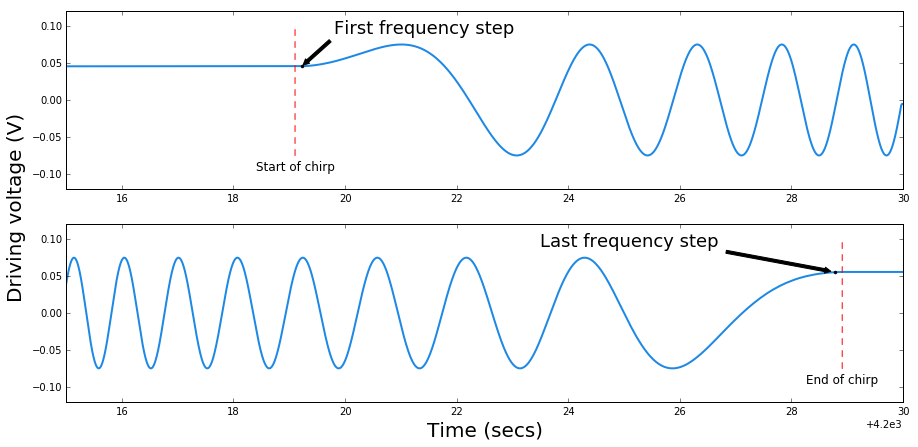

In [12]:
chirp_chunk_s = chirp[100000:300000]
t_chunk_s = t[100000:300000]
chirp_chunk_e = chirp[-300000:]
t_chunk_e = t[-300000:]
wave_s = cos(50*2*pi*t_chunk_s)+1j*sin(50*2*pi*t_chunk_s)
wave_e = cos(400*2*pi*t_chunk_e)+1j*sin(400*2*pi*t_chunk_e)
lock_s = wave_s*chirp_chunk_s
lock_e = wave_e*chirp_chunk_e
sos_s = signal.butter(6,20,'lowpass',fs=10000,output='sos')
sos_e = signal.butter(6,100,'lowpass',fs=10000,output='sos')
filt_lock_s = signal.sosfiltfilt(sos_s,lock_s)
filt_lock_e = signal.sosfiltfilt(sos_e,lock_e)

# fig,ax = subplots(2,1)
fig = plt.figure()
ax,ax1,ax2 = fig.add_subplot(111,frameon=False),fig.add_subplot(211),fig.add_subplot(212)

ax1.plot(t_chunk_s,filt_lock_s,'#1e88e5',linewidth=2)
ax1.plot(t_chunk_s[92236],filt_lock_s[92236],'k.')
ax1.annotate('First frequency step', xy=(t_chunk_s[92236],filt_lock_s[92236]), 
             xytext=(19.8, 0.09),fontsize=18,
             arrowprops=dict(width=3,headwidth=6,headlength=6,facecolor='black', shrink=0.04)
              )
ax1.set_xlim(15,30)
ax1.set_ylim(-0.12,0.12)
ax2.plot(t_chunk_e,filt_lock_e,'#1e88e5',linewidth=2)
ax2.plot(t_chunk_e[216688],filt_lock_e[216688],'k.')
ax2.annotate('Last frequency step', xy=(t_chunk_e[216688], filt_lock_e[216688]), 
             xytext=(4223.5, 0.09),fontsize=18,
             arrowprops=dict(width=3,headwidth=6,headlength=6,facecolor='black', shrink=0.04)
        )
ax2.set_xlim(4215,4230)
ax2.set_ylim(-0.12,0.12)
x = linspace(t_chunk_s[92236],t_chunk_e[216688],34998)
dx = x[1]-x[0]
start,end = t_chunk_s[92236]-dx,t_chunk_e[216688]+dx

ax1.annotate('Start of chirp', xy=(start,0.1), xytext=(start, -0.09),
             fontsize=12,arrowprops = {'arrowstyle': '-', 'ls': 'dashed',
                                      'color':'r'},ha='center',va='center',
            )
ax2.annotate('End of chirp', xy=(end,0.1), xytext=(end, -0.09),
             fontsize=12,arrowprops = {'arrowstyle': '-', 'ls': 'dashed',
                                      'color':'r'},ha='center',va='center',
            )
ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
grid(False)
xlabel('Time (secs)',size=20)
ax.set_ylabel('Driving voltage (V)',size=20)
ax.yaxis.labelpad=20
# savefig('2020-03-13 Data seperation',transparent=True)
# xlim(4210,4235)

# xlim(19.22,19.23)
# xlim(4228.78,4228.8)
# ylim(0.052,0.057)

In [13]:
x = linspace(19.223600453694974,4228.788899803379,34998)
dx = x[1]-x[0]
start,end = 19.223600453694974-dx,4228.788899803379+dx
print('dx: ',around(x[1]-x[0],3))
print('Start time:',around(start,3))
print('End time:',around(end,3))

dx:  0.12
Start time: 19.103
End time: 4228.909


In [14]:
fs = 10000
# start = int(38.65*fs)
# end = int(2039.7*fs)
start = int(19.055*fs)
end = int(4228.98*fs)

geo = dat[start:end,0]
chirp = dat[start:end,1]
tip = lev[start:end]
print(len(geo),len(chirp),len(tip))
# cur = dat[start:end,0]
# geo = dat[start:end,1]
# chirp = dat[start:end,2]
# geo_in = dat[start:end,3]
# tip = dat[start:end,6]
# LIY = dat[start:end,8]

t = linspace(0,len(chirp)/10000,len(chirp))

42099249 42099249 42099249


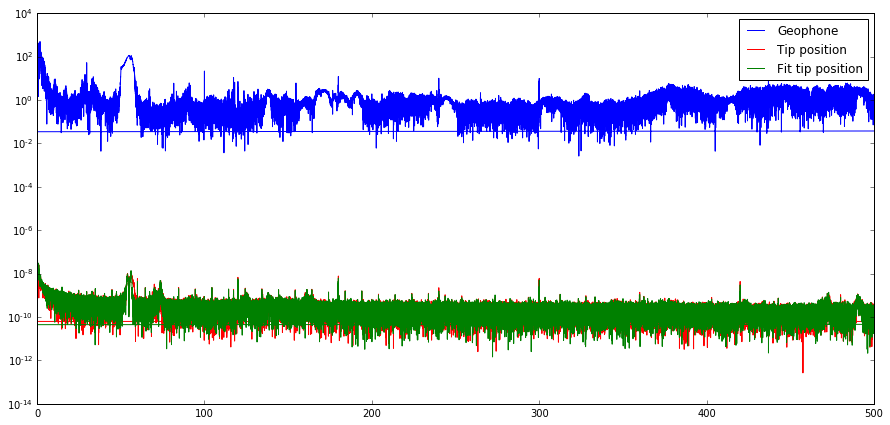

In [15]:
# x=linspace(0,100,100000)
# plot(x,sin(1*2*pi*x))
# plot(x,sin(1*2*pi*x + 0.25*pi))
# plot(x,sin(1*2*pi*x)+sin(1*2*pi*x+0.25*pi))
# xlim(0,10)
freq = fft.fftfreq(len(geo[:1000000]),1/10000)
geo_fft= fft.fft(geo[:1000000])
tip_fft  = fft.fft(tip[:1000000])
tip_fit_fft = fft.fft(lev[:1000000])

semilogy(freq,absolute(geo_fft),'b',label='Geophone')
semilogy(freq,absolute(tip_fft),'r',label='Tip position')
semilogy(freq,absolute(tip_fit_fft),'g',label='Fit tip position')
xlim(0,500)
legend(loc=1)

In [16]:
# x_fft = fft.fft(sin(1*2*pi*x))
# x2_fft = fft.fft(sin(1*2*pi*x+0.25*pi))
# x3_fft = fft.fft(sin(1*2*pi*x+0.25*pi)+sin(1*2*pi*x))
# freq = fft.fftfreq(len(x),1/1000)
# # semilogy(freq,absolute(x_fft))
# # semilogy(freq,absolute(x2_fft))
# # semilogy(freq,absolute(x3_fft))
# # xlim(0,10)
# print('Frequency:',freq[100])
# print('Interference: ',x_fft[100])
# print('True Signal: ',x2_fft[100])
# print('Signal: ',x3_fft[100])
# print('Estimated Signal: ',x3_fft[100]-x_fft[100])

In [17]:
def coef(w,inpt,outpt,t_array,harmonic,c1=None,fs=1000):
    
    if w*harmonic >= fs/2:
        return 0 + 0*1j
    
    ref_outpt = outpt*(np.cos(w*harmonic*2*pi*t_array)-1j*sin(w*harmonic*2*pi*t_array)) 
    ref_inpt = inpt*(np.cos(w*2*pi*t_array)-1j*sin(w*2*pi*t_array))
    
    sos = signal.butter(10, w/5, 'lowpass', fs=fs, output='sos')
    sos_harm = signal.butter(10,(w*harmonic)/5,'lowpass',fs=fs, output='sos')
    
    filt_outpt = signal.sosfiltfilt(sos_harm,ref_outpt)
    filt_inpt = signal.sosfiltfilt(sos,ref_inpt)
    
    
    lock_outpt = average(filt_outpt)
    lock_inpt = average(filt_inpt)
    
    if c1 != None:
        print(c1,end='\r')
        ref_inpt_harm = inpt*(np.cos(w*harmonic*2*pi*t_array)-1j*sin(w*harmonic*2*pi*t_array))
        filt_inpt_harm = signal.sosfiltfilt(sos_harm,ref_inpt_harm)
        lock_inpt_harm = c1*average(filt_inpt_harm)
        C = (lock_outpt-lock_inpt_harm)/lock_inpt
        return C
        
    C = lock_outpt/lock_inpt
    
    return C

In [18]:
prev = 0
harmonics = 5
steps = 35000
loc = linspace(1202,len(t),int(steps-1)).astype('int')
# loc = linspace(0,len(t),int(steps)).astype('int')
# print(loc[1])
# loc = (change_loc*fs).astype('int')
# print(len(loc))
freq_map = linspace(50,400,len(loc))
fftfreq = fft.fftfreq(int(10000/(freq_map[1]-50)),1/10000)
# print(freq_map[1]-50)
# print(fftfreq[1])
# print(np.where(absolute(fftfreq-400) <0.1))
# print(fftfreq[5000:5010])
C = np.zeros((len(fftfreq),harmonics),dtype='complex128')
# print(loc[0])
# print(len(geo),len(t),len(tip))
for w,point,i in zip(freq_map,loc,arange(len(freq_map))):
#     i = i+166
    i = i + 5000
    print(fftfreq[i],end='\r')
    input_wave=geo[prev:point]-mean(geo[prev:point])
    output_wave = tip[prev:point]
    t_split = t[prev:point]
    
    C[i,0] = coef(w,input_wave,output_wave,t_split,1,fs=10000)
    
    prev=point

prev=0
for w,point,i in zip(freq_map,loc,arange(len(freq_map))):
#     i = i + 48
#     i = i+166
    i = i + 5000
    print(fftfreq[i],end='\r')
    input_wave = geo[prev:point] - mean(geo[prev:point])
    output_wave = tip[prev:point]
    t_split = t[prev:point]
    for j in arange(harmonics-1):
        j = j +1
        C[i,j] = coef(w,input_wave,output_wave,t_split,(j+1),fs = 10000)
        
    prev = point
    
C[int(len(C[:,0])/2):,:] = flip(conj(C[1:int(len(C[:,0])/2)+1]),axis=0)

In [19]:
print(shape(C[int(len(C[:,0])/2):,:]),shape(C[1:int(len(C[:,0])/2)+1]))

(499971, 5) (499971, 5)


In [20]:
C1 = scipy.interpolate.interp1d(fftfreq,C[:,0], kind='linear',fill_value='extrapolate')
C2 = scipy.interpolate.interp1d(fftfreq,C[:,1], kind='linear',fill_value='extrapolate')
C3 = scipy.interpolate.interp1d(fftfreq,C[:,2], kind='linear',fill_value='extrapolate')
C4 = scipy.interpolate.interp1d(fftfreq,C[:,3], kind='linear',fill_value='extrapolate')
C5 = scipy.interpolate.interp1d(fftfreq,C[:,4], kind='linear',fill_value='extrapolate')

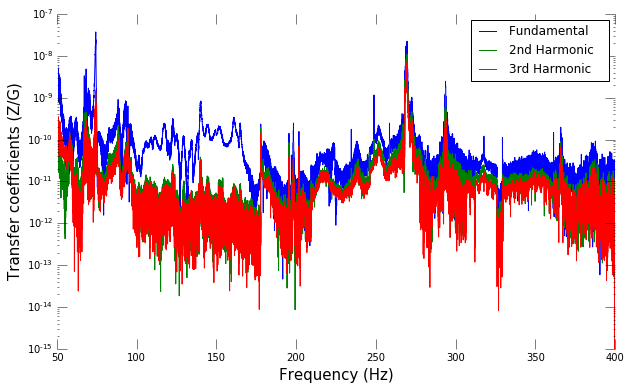

In [21]:
figsize(10,6)

# print(freq_map[1]-50)
# print(fftfreq[379])

fig,ax=subplots(1,1)

semilogy(fftfreq,absolute(C[:,0]),'b',label='Fundamental    ')
semilogy(fftfreq,absolute(C[:,1]),'g',label='2nd Harmonic')
semilogy(fftfreq,absolute(C[:,2]),'r',label='3rd Harmonic')
xlim(50,400)
tick_params(size= 10)
grid(False)
for spine in ax.spines.values():
    spine.set_edgecolor('white')
xlabel('Frequency (Hz)',size=15)
ylabel('Transfer coefficients (Z/G)',size = 15)
legend(loc=1,fontsize=12)
# savefig('2020-3-13 Matrix coefficients lockin OFF')

In [22]:
folder_loc = '2020-03-13/Noisy Calibration Lockin 62/'
file_loc = '2020-03-13-22-14_noisy62_cal001.dat'
dat_cal = np.loadtxt(folder_loc+file_loc,skiprows=76)

for filename in os.listdir(folder_loc):
    if filename == file_loc:
        pass
    try:
        tempdata = np.loadtxt(folder_loc+filename, skiprows=76)
        dat_cal = np.concatenate((dat_cal,tempdata))
        print(filename,end='\r')
    except:
        print('ERROR: ',filename)

In [23]:
print(shape(dat_cal))
cur_cal = dat_cal[:,0]
geo_cal = dat_cal[:,1]
tip_cal = dat_cal[:,6]
liy_cal = dat_cal[:,8]
# geo_cal = dat_cal[:,1]

# liy_cal = dat_cal[:,10]
t_cal = linspace(0,len(geo_cal)/10000,len(geo_cal))

(3941000, 9)


In [24]:
n = 10000
c = liy_cal[:int(300*fs)]
seg_c = np.zeros(((len(c))//(n),n),dtype=np.complex)
c_cal_temp = np.copy(c)
j = 0
while len(c_cal_temp) >= n:
    seg_c[j,:] = fit_cancel(c_cal_temp[:n])
    j+=1
    c_cal_temp = c_cal_temp[n:]
    
for i in range(0,len(seg_c[:,0])):
    seg_c[i,:] = np.fft.fft(seg_c[i,:])
    
seg_c = mean(seg_c,axis=0)
freqs = np.fft.fftfreq(len(seg_c),1/10000)


(array([1000], dtype=int64),)
(array([1000], dtype=int64),)


(0, 2000)

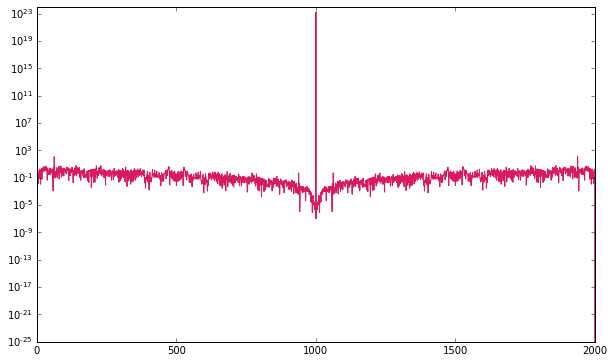

In [25]:
A = np.zeros(len(seg_c),dtype='complex128')
w_mod = 1000
print(np.where(freqs==w_mod))
fft_c = fft.fft(liy_cal[int(200*fs):int(201*fs)])
frq_c = np.fft.fftfreq(len(fft_c),1/10000)
print(np.where(frq_c==w_mod))
# print(frq_c[1],freqs[1])
for i,frq in enumerate(freqs[:int(len(seg_c)/2)]):
    A[i] = seg_c[absolute(i-1000)]/seg_c[i]
A = scipy.interpolate.interp1d(freqs,A,kind='linear',fill_value='extrapolate')
# A[int(len(seg_c)/2):] = np.flip(conj(A[:int(len(seg_c)/2)]))
c_alias = np.zeros(len(seg_c),dtype='complex128')
for i in arange(int(2*w_mod)):
    c_alias[i] = A(absolute(frq_c[1000]-frq_c[i]))*fft_c[absolute(1000-i)]
c_alias[int(len(seg_c)/2):] = np.flip(conj(c_alias[:int(len(seg_c)/2)]))

semilogy(frq_c[:int(len(fft_c)/2)],absolute(1e9*c_alias[:int(len(fft_c)/2)])**2,'#d81b60')
xlim(0,2000)

C:\Users\jgoet\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  


(1e-10, 2000)

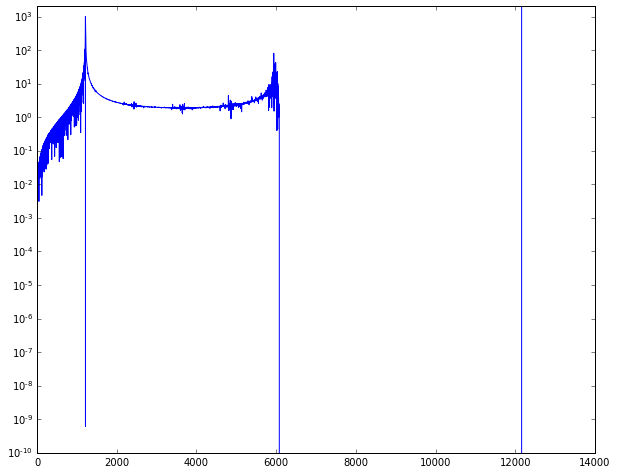

In [72]:
semilogy(absolute(A(freqs)))
ylim(0,2000)

10000 10000


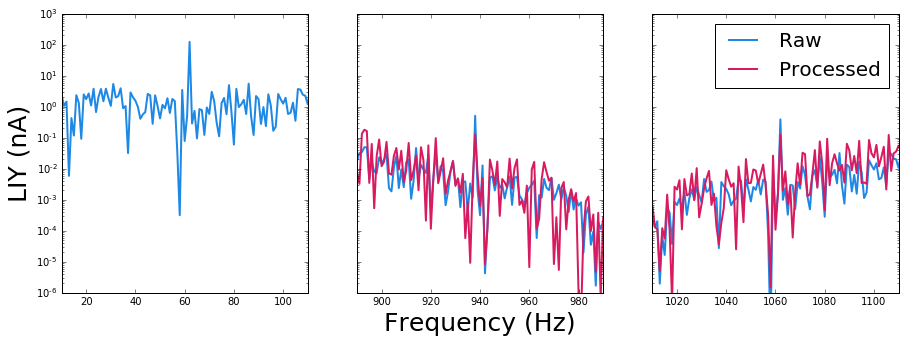

In [76]:
fig,ax = subplots(1,3)
figsize(15,5)
print(len(seg_c),len(c_alias))
ax[0].semilogy(frq_c[:int(len(fft_c)/2)],absolute(1e9*fft_c[:int(len(fft_c)/2)])**2,'#1e88e5',linewidth=2)
ax[1].semilogy(frq_c[:int(len(fft_c)/2)],absolute(1e9*fft_c[:int(len(fft_c)/2)])**2,'#1e88e5',linewidth=2)
ax[2].semilogy(frq_c[:int(len(fft_c)/2)],absolute(1e9*fft_c[:int(len(fft_c)/2)])**2,'#1e88e5',label='Raw',linewidth=2)


ax[1].semilogy(frq_c[:int(len(fft_c)/2)],absolute(1e9*fft_c[:int(len(fft_c)/2)]-
                                                  1e9*c_alias[:int(len(fft_c)/2)])**2,'#d81b60',linewidth=2)
ax[2].semilogy(frq_c[:int(len(fft_c)/2)],absolute(1e9*fft_c[:int(len(fft_c)/2)]-
                                                  1e9*c_alias[:int(len(fft_c)/2)])**2,'#d81b60',label='Processed',linewidth=2)

ax[1].set_xlabel('Frequency (Hz)',size=25)
ax[0].set_ylabel('LIY (nA)',size=25)
ax[1].tick_params(axis='y',labelleft=False)
ax[2].legend(loc=0,fontsize=20)
ax[2].tick_params(axis='y',labelleft=False)
# ax[1].set_xticklabels(['900','920','940','960','980','1000'])
ax[0].set_xlim(10,110)
ax[1].set_xlim(890,990)
ax[2].set_xlim(1010,1110)
ax[0].set_ylim(1e-6,1e3)
ax[1].set_ylim(1e-6,1e3)
ax[2].set_ylim(1e-6,1e3)
savefig('2020-4-10 Spectroscopic aliasing',transparent=True)

In [27]:
G = fft.fft(geo_cal[:100000])
omega = fft.fftfreq(len(geo_cal[:100000]),1/10000)
G = scipy.interpolate.interp1d(omega,G,kind='linear',fill_value='extrapolate')

In [28]:
tip_omega = C1(omega)*G(omega) + C2(omega/2)*G(omega/2) + C3(omega/3)*G(omega/3) + C4(omega/4)*G(omega/4)
tip_vib = fft.ifft(tip_omega)
# liy_omega = C1(omega)*G(omega) + C2(omega/2)*G(omega/2)+ C3(omega/3)*G(omega/3) + C4(omega/4)*G(omega/4)  
# liy_vib = fft.ifft(liy_omega)

In [29]:
tf = cancel.Cancel(geo_cal[100000:3000000]-mean(geo_cal[100000:3000000]),tip_cal[100000:3000000],1/10000,p=[200000,50000,5])
tip_vib_vec  = tf.create_drive(geo_cal[:100000]-mean(geo_cal[:100000]))

In [30]:
from stmpy.color.palette import solarized

(1e-13, 1e-06)

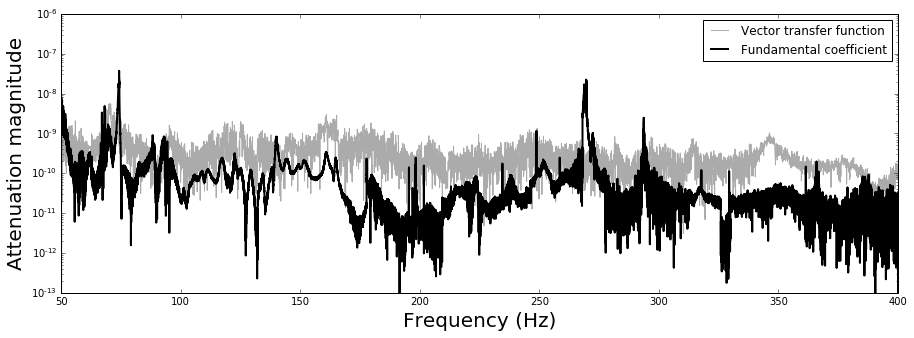

In [31]:
semilogy(tf.freqs[:int(len(tf.freqs)/2)],absolute(tf.transf(tf.freqs[:int(len(tf.freqs)/2)])), 
         color='#ababab',label='Vector transfer function')
semilogy(fftfreq,absolute(C[:,0]),'-', color='k', lw=2,label='Fundamental coefficient')
xlabel('Frequency (Hz)',size=20)
ylabel('Attenuation magnitude',size=20)
legend(loc=0)
# xlim(58,66)
xlim(50,400)
ylim(1e-13,1e-6)
# savefig('Vector vs Fundamental transfer')

In [32]:
tip_sig = tip_cal[:100000-10]-tip_vib[10:]-mean(tip_cal[:100000-10])
tip_sig_vec = tip_cal[:100000]-tip_vib_vec-mean(tip_cal[:100000])
# liy_sig = liy_cal[:100000]-liy_vib

1.0046154909997286e-11 -1.1991845090000069e-11
(-1.3300135381280453e-12-1.4150202478055883e-28j)
-3.8695283e-08
(8.407716205482391e-13+1.0060363071691135e-27j)


(-12, 12)

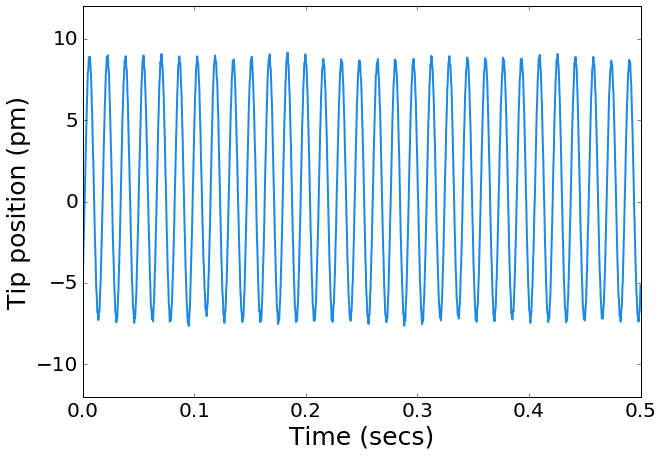

In [33]:
figsize(10,7)
print(max(tip_cal[:100000]-mean(tip_cal[:100000])),min(tip_cal[:100000]-mean(tip_cal[:100000])))
plot(t_cal[:100000],1e12*(tip_cal[:100000]-mean(tip_cal[:100000])),'#1e88e5',linewidth=2,label='Raw')
# plot(t_cal[:100000],9+0*t_cal[:100000],'#004D40',label='Tip amplitude = 22.01 pm')
# plot(t_cal[:100000],-7.2+0*t_cal[:100000],'#004D40')
# plot(t_cal[:100000-10],1e12*tip_sig.real,'#d81b60',linewidth=2,label='Matrix cancelled')
# plot(t_cal[:100000],1e12*tip_sig_vec.real,'#ffc107',linewidth=2,label='Vector cancelled')
print(tip_sig[10])
print(tip_cal[10])
print(tip_sig_vec[10])
# plot(t_cal[:100000],1e12*liy_cal[:100000],'#6d9eeb',label='Raw')
# plot(t_cal[:100000],1e12*liy_sig,'r',label='Processed')
tick_params(labelsize=20)
xlabel('Time (secs)',size=25)
ylabel('Tip position (pm)',size=25)
# legend(loc=3,fontsize=20)
grid(False)

xlim(0,0.5)
ylim(-12,12)
# savefig('2020-4-8 Z noise',transparent=True)

In [34]:
rms_raw = np.zeros(int(len(tip_sig)/100),dtype='complex128')
rms_mat = np.zeros(int(len(tip_sig)/100),dtype='complex128')
rms_vec = np.zeros(int(len(tip_sig)/100),dtype='complex128')
canc_mat = np.zeros(int(len(tip_sig)/100))
canc_vec = np.zeros(int(len(tip_sig)/100))
prev=0
for i in arange(len(rms_raw)):
    rms_raw[i] = sqrt(mean((tip_cal[prev:prev+1000]-mean(tip_cal[prev:prev+1000]))**2))
    rms_mat[i] = sqrt(mean((tip_sig[prev:prev+1000])**2))
    rms_vec[i] = sqrt(mean((tip_sig_vec[prev:prev+1000])**2))
    canc_mat[i] = 100-100*rms_mat[i]/rms_raw[i]
    canc_vec[i] = 100-100*rms_vec[i]/rms_raw[i]
print('Mean Matrix:',mean(canc_mat))
print('STD Matrix: ',std(canc_mat))
print('Mean Vector:',mean(canc_vec))
print('STD Vector:',std(canc_vec))

Mean Matrix: 51.78903744524768
STD Matrix:  7.105427357601002e-15
Mean Vector: 83.34304829661164
STD Vector: 2.842170943040401e-14


C:\Users\jgoet\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  # This is added back by InteractiveShellApp.init_path()
C:\Users\jgoet\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  if sys.path[0] == '':


(1.0, 1000000.0)

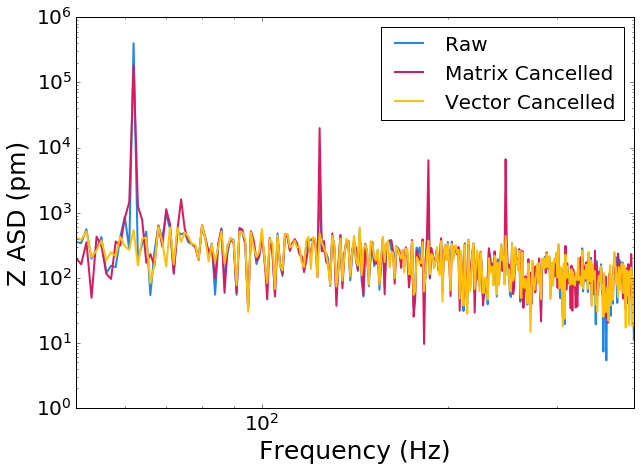

In [35]:
tip_fft = fft.fft(tip_cal[:100000]*1e12)
tip_mat_fft = fft.fft(tip_sig*1e12)
tip_vec_fft = fft.fft(tip_sig_vec*1e12)
freqs = fft.fftfreq(len(tip_sig),1/10000)
freqs2 = fft.fftfreq(len(tip_fft),1/10000)
loglog(freqs2[:int(len(tip_fft)/2):10],absolute(tip_fft[:int(len(tip_fft)/2):10]),'#1e88e5',label='Raw',linewidth=2)
loglog(freqs[:int(len(tip_mat_fft)/2):10],absolute(tip_mat_fft[:int(len(tip_mat_fft)/2):10]),'#d81b60',label='Matrix Cancelled',linewidth=2)
loglog(freqs2[:int(len(tip_fft)/2):10],absolute(tip_vec_fft[:int(len(tip_fft)/2):10]),'#ffc107',label='Vector Cancelled',linewidth=2)
legend(loc=0,fontsize=20)
tick_params(labelsize=20)
xlabel('Frequency (Hz)',size=25)
ylabel('Z ASD (pm)',size=25)
xlim(50,400)
ylim(1e0,1e6)
# savefig('2020-4-8 Mt_vec freq',transparent=True)
# ylim(1e-12,1e-5)

In [36]:
# liy_fft = fft.fft(liy_cal[:100000])
# liy_sig_fft = fft.fft(liy_sig)
# freqs = fft.fftfreq(len(liy_sig),1/10000)
# semilogy(freqs,absolute(liy_fft),'#6d9eeb',label='Raw')
# semilogy(freqs,absolute(liy_sig_fft),'r',label='Processed')
# xlabel('Frequency (Hz)',size=)
# xlim(0,300)
# ylim(1e-10,1e-6)

In [37]:
# folder_loc = '2020-03-13/Spec Sweep Noisy 170 v2/'
# file_loc = '2020-03-13-21-53_noisy170_spec001.dat'
folder_loc = '2020-03-13/Spec Sweep Noisy 62/'
file_loc = '2020-03-13-20-57_spec_noisy2001.dat'
# folder_loc = '2020-03-13/Spec Sweep Noisy 170/'
# file_loc = '2020-03-13-20-43_spec_noisy1001.dat'

dat_spec = np.loadtxt(folder_loc+file_loc,skiprows=76)

for filename in os.listdir(folder_loc):
    if filename == file_loc:
        pass
    try:
        tempdata = np.loadtxt(folder_loc+filename, skiprows=76)
        dat_spec = np.concatenate((dat_spec,tempdata))
        print(filename,end='\r')
    except:
        print('ERROR: ',filename)

In [38]:
cur = dat_spec[:,0]
geo = dat_spec[:,1]
speaker = dat_spec[:,2]
bias_mod = dat_spec[:,4]
bias = dat_spec[:,5]
Z = dat_spec[:,6]
LIY = dat_spec[:,8]

t = linspace(0,len(cur)/10000,len(cur))
print(len(cur),len(t),shape(dat_spec))

7583000 7583000 (7583000, 9)


1000


(14.9, 17)

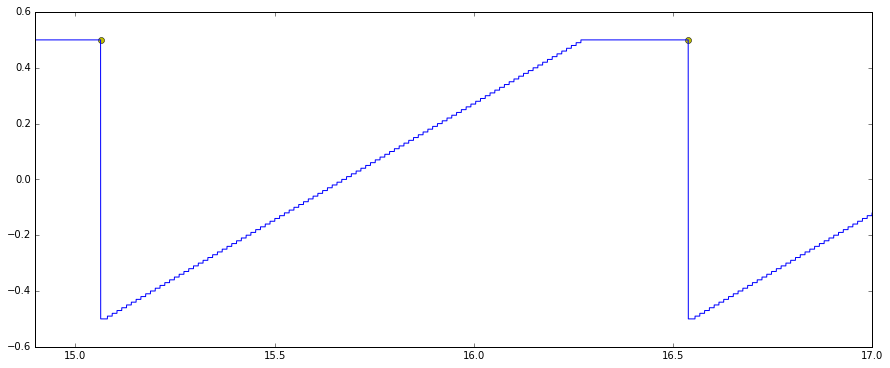

In [39]:
figsize(15,6)
dt = t[1]
grad = np.gradient(bias,dt)
brk_pnt = np.argsort(grad)[:1000]
count = 0
for j in brk_pnt:
    if grad[j] < -1000:
        count = count+1
print(count)

brk_pnt = np.argsort(grad)[:count]
brk_pnt = np.sort(brk_pnt)
# print(brk_pnt)
for idx,point in enumerate(brk_pnt):
    temp_pnt = point
    brk_pnt[np.where(absolute(brk_pnt-point)<10)] = 0
    brk_pnt[idx] = point
brk_pnt = np.sort(brk_pnt[brk_pnt != 0])
# brk_pnt = np.append(brk_pnt,-1)
# print(brk_pnt)

plot(t[brk_pnt],bias[brk_pnt],'yo')
plot(t,bias)
grid(False)
# plot(t,grad)
start = 0
xlim(14.9,17)
# ylim(-5009,-4900)

In [40]:
start = brk_pnt[0]+1
end = brk_pnt[-1]

cur_cut = dat_spec[:start,0]
geo_cut = dat_spec[:start,1]
speaker_cut = dat_spec[:start,2]
bias_mod_cut = dat_spec[:start,4]
bias_cut = dat_spec[:start,5]
Z_cut = dat_spec[:start,6]
LIY_cut = dat_spec[:start,8]

t = linspace(0,len(cur_cut)/10000,len(cur_cut))
print(len(cur_cut),len(t))

150635 150635


In [41]:
start = brk_pnt[0]+3
end = brk_pnt[-1]+2

cur_cut = dat_spec[start:end,0]
geo_cut = dat_spec[start:end,1]
speaker_cut = dat_spec[start:end,2]
bias_mod_cut = dat_spec[start:end,4]
bias_cut = dat_spec[start:end,5]
Z_cut = dat_spec[start:end,6]
LIY_cut = dat_spec[start:end,8]

t = linspace(0,len(cur_cut)/10000,len(cur_cut))
print(len(cur_cut),len(t))

7356756 7356756


998 2000
[-14743 -14743 -14743 -14743 -14743 -14743 -14743 -14743 -14743 -14743]


(-5, 100)

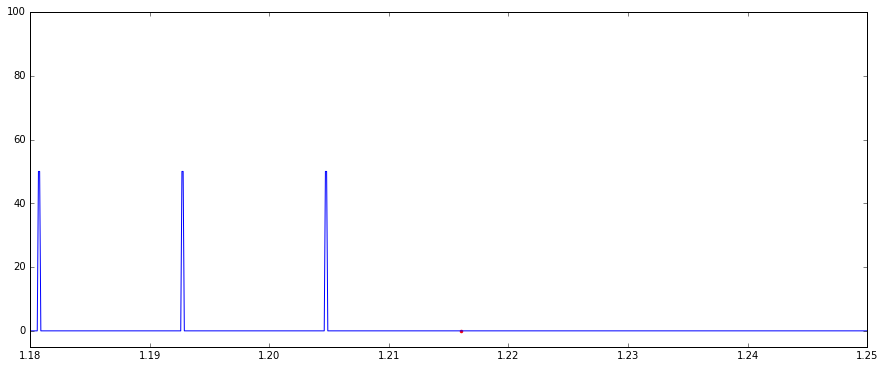

In [42]:
figsize(15,6)
dt = t[1]
grad = np.gradient(bias_cut,dt)
swp_pnt = np.argsort(grad)[:2000]
count = 0
for j in swp_pnt:
    if grad[j] < -1000:
        count = count+1
print(count,len(swp_pnt))
swp_pnt = (np.sort(swp_pnt))
swp_pnt = swp_pnt[:count]

swp_pnt = np.argsort(grad)[:2000]
swp_pnt = np.sort(swp_pnt)
# print(brk_pnt)
for idx,point in enumerate(swp_pnt):
    temp_pnt = point
    swp_pnt[np.where(absolute(swp_pnt-point)<10)] = 0
    swp_pnt[idx] = point
#     swp_pnt = np.sort(swp_pnt)
swp_pnt = np.sort(swp_pnt[swp_pnt != 0])
# swp_pnt = np.append(swp_pnt,len(grad_brk)-1)
print(swp_pnt[:10]-swp_pnt[1:11])
plot(t[swp_pnt-2580],grad[swp_pnt-2500],'r.')
# plot(t,bias_cut)
plot(t,grad)
start = 1.18
xlim(start,1.25)
ylim(-5,100)

200
[  168   288   408   528   648   768   888  1008  1128  1248  1368  1488
  1608  1728  1848  1968  2088  2208  2328  2448  2568  2688  2808  2928
  3048  3168  3288  3408  3528  3648  3768  3888  4008  4128  4248  4368
  4488  4608  4728  4848  4968  5088  5208  5328  5448  5568  5688  5808
  5928  6048  6168  6288  6408  6528  6648  6768  6888  7008  7128  7248
  7368  7488  7608  7728  7848  7968  8088  8208  8328  8448  8568  8688
  8808  8928  9048  9168  9288  9408  9528  9648  9768  9888 10008 10128
 10248 10368 10488 10608 10728 10848 10968 11088 11208 11328 11448 11568
 11688 11808 11928 12048 14739]


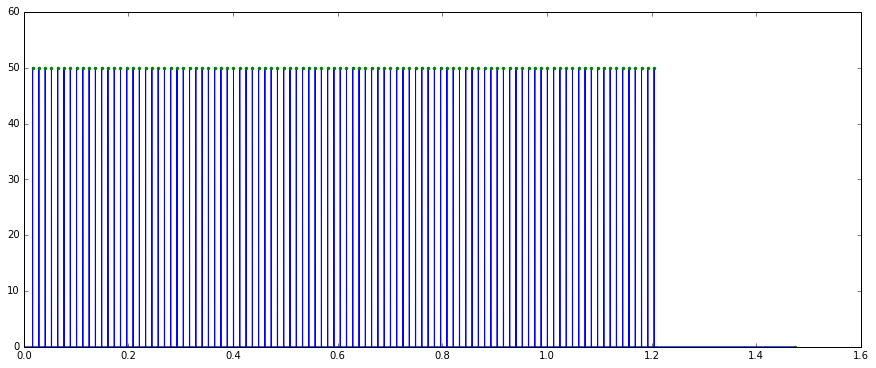

In [43]:
prev = 0
for brk in swp_pnt:
    grad_brk = grad[prev:brk]
    brk_pnt_2 = np.flip(np.argsort(grad_brk))[:200]
    brk_pnt_2 = (np.sort(brk_pnt_2))
    
    count = 0
    for j in brk_pnt_2:
        if grad_brk[j] > 20:
            count = count+1
    print(count)
#     plot(t[prev:brk],grad_brk)
#     plot(t[brk_pnt_2],grad_brk[brk_pnt_2],'.')
#     xlim(0,0.2)
    break

step_pnt = np.flip(np.argsort(grad_brk))[:200]
step_pnt = -np.sort(-step_pnt)
# print(brk_pnt)
for idx,point in enumerate(step_pnt):
    temp_pnt = point
    step_pnt[np.where(absolute(step_pnt-point)<10)] = 0
    step_pnt[idx] = point
step_pnt = np.sort(step_pnt[step_pnt != 0])
step_pnt = np.append(step_pnt,len(grad_brk)-1)
plot(t[prev:brk],grad_brk)
plot(t[step_pnt],grad_brk[step_pnt],'.')
print(step_pnt)

In [44]:

#Initialize the calibration array of initial current values
I_s,reps = np.zeros(len(step_pnt)),np.zeros(len(step_pnt))
prev = 0 
#Iterate through each step within a sweep and 
# calculate the initial current values and 
# the numebr of points in that step
for idx,point in enumerate(step_pnt):
    I_s[idx] = mean(cur_cut[prev:point])
    reps[idx] = point-prev
    prev = point
reps[-1] = reps[-1] +1
#Create an array of initial current values that are
#  the same shape as the sweep
I_s = repeat(I_s,reps.astype('int'))

print(len(cur_cut[:brk]),len(I_s),I_s[0])

14740 14740 -7.432592920238096e-10


In [45]:
G_sweep = fft.fft(geo_cut)
omega = fft.fftfreq(len(geo_cut),1/10000)
G_sweep = scipy.interpolate.interp1d(omega,G_sweep,kind='linear',fill_value='extrapolate')

In [46]:
tip_swp_omega = C1(omega)*G_sweep(omega) + C2(omega/2)*G_sweep(omega/2)+ C3(omega/3)*G_sweep(omega/3) + C4(omega/4)*G_sweep(omega/4)  
tip_swp_vib = fft.ifft(tip_swp_omega)

In [47]:
# tf = cancel.Cancel(geo_cal[100000:3000000]-mean(geo_cal[100000:3000000]),tip_cal[100000:3000000],1/10000,p=[200000,50000,5])
tip_vib_vec  = tf.create_drive(geo_cut-mean(geo_cut))

In [48]:
# liy_sig_brk = LIY_cut[:brk]-I_n*liy_swp_vib[:brk]/1e-9
kappa = -24929385877.175434
cur_swp_noise = exp(-kappa*(tip_swp_vib-mean(tip_swp_vib)))
cur_vec_noise = exp(-kappa*(tip_vib_vec-mean(tip_vib_vec)))

In [49]:
folder_loc = '2020-03-13/'
file_loc = 'Bias-Spectroscopy00003.dat'
dat = np.loadtxt(folder_loc+file_loc,skiprows=124)
bias_calc_avg = dat[:,0]
cur_avg = dat[:,1]
liy_avg = dat[:,2]

101


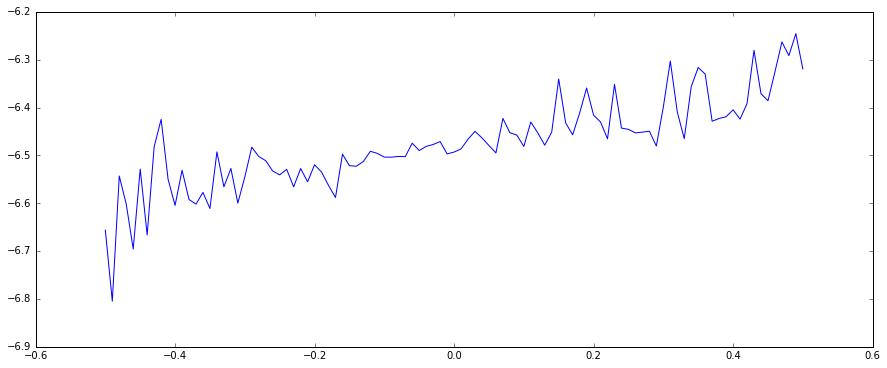

In [50]:
plot(bias_calc_avg,1e12*liy_avg)
print(len(liy_avg))

C:\Users\jgoet\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  """Entry point for launching an IPython kernel.


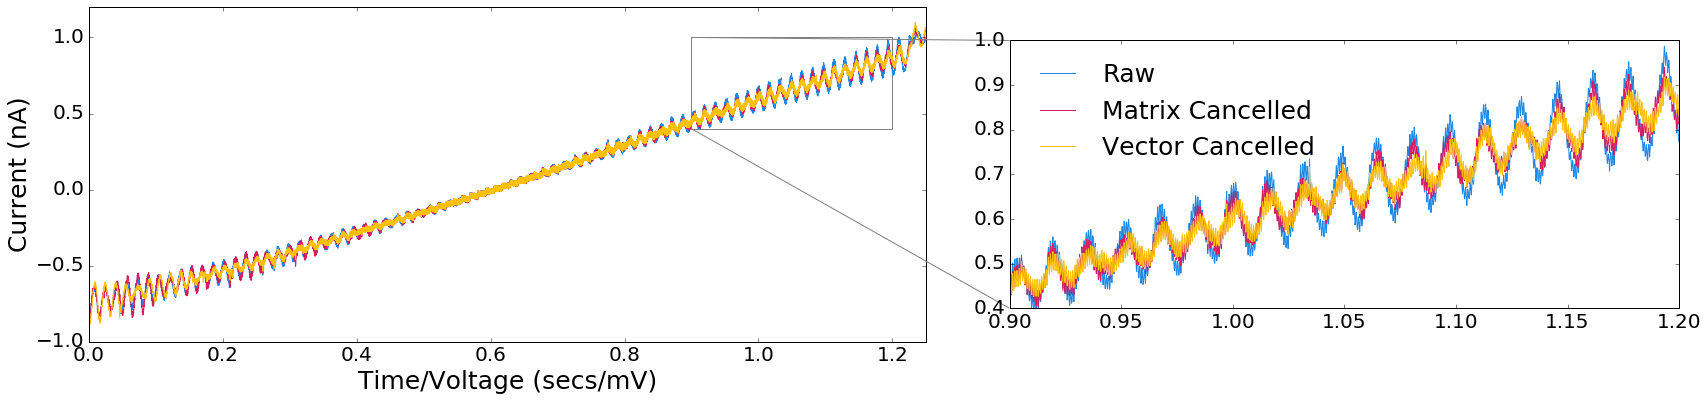

In [51]:
from mpl_toolkits.axes_grid.inset_locator import (
    inset_axes, InsetPosition,mark_inset)
delay=12
fig,ax1 = subplots()
figsize(10,10)

ax1.plot(t[:brk-delay],1e9*cur_cut[:brk-delay],'#1e88e5',label='Raw')
# ax1.plot(t[:brk-2580:60],1e9*avg_swp[::60],label='Ground Truth')
ax1.plot(t[:brk-delay],1e9*(cur_cut[:brk-delay]/cur_swp_noise[delay:brk]),'#d81b60',label='Matrix Cancelled')
ax1.plot(t[:brk-delay],1e9*(cur_cut[:brk-delay]/cur_vec_noise[delay:brk]),'#ffc107',label='Vector Cancelled')
ax1.grid(False)
ax1.tick_params(labelsize=20)
# title('Initial current calculation',size=25)
ax1.set_xlabel('Time/Voltage (secs/mV)',size=25)
ax1.set_ylabel('Current (nA)',size=25)

ax1.set_xlim(0,1.25)
ax1.set_ylim(-1,1.2)
ax2 = plt.axes([0,0,1,1])
ip = InsetPosition(ax1, [1.1,0.1,0.8,0.8])
ax2.set_axes_locator(ip)
mark_inset(ax1, ax2, loc1=2, loc2=3, fc="none", ec='0.5')

ax2.plot(t[:brk-delay],1e9*cur_cut[:brk-delay],'#1e88e5',label='Raw')
# plot(t[:brk-2580:60],1e9*avg_swp[::60])
ax2.plot(t[:brk-delay],1e9*(cur_cut[:brk-delay]/cur_swp_noise[delay:brk]),'#d81b60',label='Matrix Cancelled')
ax2.plot(t[:brk-delay],1e9*(cur_cut[:brk-delay]/cur_vec_noise[delay:brk]),'#ffc107',label='Vector Cancelled')
ax2.grid(False)
ax2.tick_params(labelsize=20)
ax2.set_xlim(0.9,1.2)
ax2.set_ylim(0.4,1)
ax2.legend(loc=2, fontsize = 25,fancybox=True, framealpha=0)
# ylim(-0.025,0.06)
# ylim(-0.1e-9,0.2e-9)

# savefig('2020-04-10 voltage sweep matrix-vec cancellation',transparent=True)

In [53]:
# prev = 0
# avg_swp = np.zeros(len(cur_cut[0:(swp_pnt[0]-2580)/120]),dtype=type(cur_cut[0]))
# print(len(avg_swp))
# for pnt in swp_pnt[:15]:
# #     print(len(avg_swp),len(cur_cut[prev:pnt-2000]))
#     x = (pnt-prev) -len(avg_swp)
#     print(prev,pnt,x,end='\r')
#     np.mean(cur_cut[prev:pnt-x])
#     avg_swp = avg_swp + cur_cut[prev:pnt-x]
#     prev=pnt
# avg_swp = avg_swp/len(swp_pnt)

123
122


(-0.8, 1)

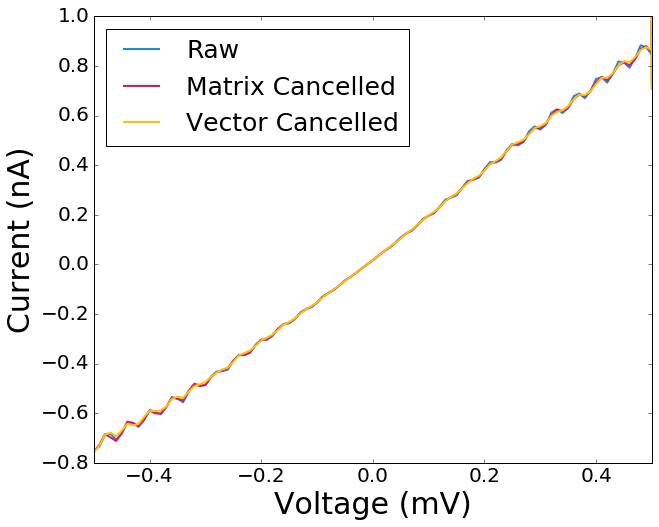

In [54]:
figsize(10,8)
cur_swp_one = np.mean(cur_cut[:7356720].reshape(-1, 120), axis=1)
mat_swp_one = np.mean((cur_cut[:7356720]/cur_swp_noise[:7356720]).reshape(-1, 120), axis=1)
vec_swp_one = np.mean((cur_cut[:7356720]/cur_vec_noise[:7356720]).reshape(-1, 120), axis=1)

print(len(bias_cut[:brk-delay-1:120]))
print(len(cur_swp_one[:int((brk-delay)/120)]))
plot(bias_cut[:brk-delay:120],1e9*cur_swp_one[:int(1+(brk-delay)/120)],'#1e88e5',label='Raw',linewidth=2)
# plot(bias_calc_avg,1e9*cur_avg,'b',label='Nanonis averaged output',linewidth=2)
plot(bias_cut[:brk-delay:120],1e9*mat_swp_one[:int(1+(brk-delay)/120)],'#d81b60',label='Matrix Cancelled',linewidth=2)
plot(bias_cut[:brk-delay:120],1e9*(vec_swp_one[:int(1+(brk-delay)/120)]),'#ffc107',label='Vector Cancelled',linewidth=2)
legend(loc=0,fontsize=25)
xlabel('Voltage (mV)',size=30)
ylabel('Current (nA)', size=30)
tick_params(labelsize=20)
xlim(-0.5,0.5)
ylim(-0.8,1)
# savefig('2020-4-10 I V curve ',transparent=True)

-0.0007294704018794285
0.0013413522304517311


(10.0, 1000000.0)

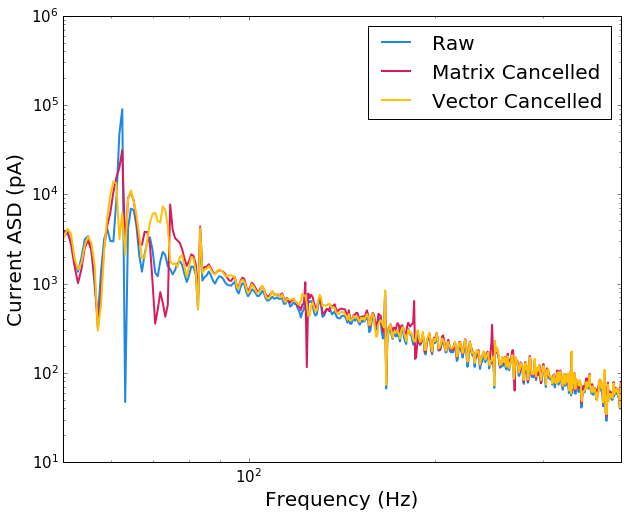

In [55]:
fig,ax1 = subplots()
figsize(10,8)
    
fft_cur_swp = fft.fft(1e9*cur_cut[:brk-delay])
fft_cur_mat = fft.fft(1e9*(cur_cut[:brk-delay]/cur_swp_noise[delay:brk]))
fft_cur_vec = fft.fft(1e9*(cur_cut[:brk-delay]/cur_vec_noise[delay:brk]))
frq_swp = fft.fftfreq(len(fft_cur_swp),1/10000)

ax1.loglog(frq_swp[:int(len(frq_swp)/2)],absolute(fft_cur_swp[:int(len(frq_swp)/2)])**2,'#1e88e5',label='Raw',linewidth=2)
ax1.loglog(frq_swp[:int(len(frq_swp)/2)],absolute(fft_cur_mat[:int(len(frq_swp)/2)])**2,'#d81b60',label='Matrix Cancelled',linewidth=2)
ax1.loglog(frq_swp[:int(len(frq_swp)/2)],absolute(fft_cur_vec[:int(len(frq_swp)/2)])**2,'#ffc107',label='Vector Cancelled',linewidth=2)
print(1-absolute(sqrt(mean(fft_cur_mat[:1000]**2))/sqrt(mean(fft_cur_swp[:1000]**2))))
print(1-absolute(sqrt(mean(fft_cur_vec[:1000]**2))/sqrt(mean(fft_cur_swp[:1000]**2))))
ax1.legend(loc=1,fontsize=20)
ax1.tick_params(labelsize=15)
ax1.set_xlabel('Frequency (Hz)',size=20)
ax1.set_ylabel('Current ASD (pA)',size=20)

ax1.set_xlim(50,400)
ax1.set_ylim(1e1,1e6)
# ax2 = plt.axes([0,0,1,1])
# ip = InsetPosition(ax1, [0.4,0.4,0.5,0.5])
# ax2.set_axes_locator(ip)
# mark_inset(ax1, ax2, loc1=2, loc2=3, fc="none", ec='0.5')
# ax2.plot(t[:brk-delay],1e9*cur_cut[:brk-delay],'#1e88e5',label='Raw')
# savefig('2020-4-10 IV sweep fft',transparent =True)

(1, 6)

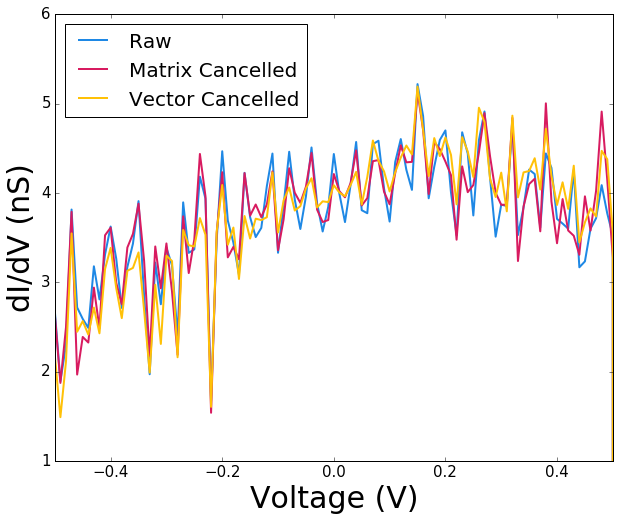

In [56]:
v_ac = bias_mod_cut-mean(bias_mod_cut)
p=15
cur_mat = (cur_cut[:-delay]/cur_swp_noise[delay:])
cur_vec = (cur_cut[:-delay]/cur_vec_noise[delay:])

mod_cur = v_ac[p:]*cur_cut[:-p]
mod_mat = v_ac[p:-delay]*cur_mat[:-p]
mod_vec = v_ac[p:-delay]*cur_vec[:-p]

sos = signal.butter(8,500,'lowpass',fs=10000,output='sos')
cur_filt = signal.sosfiltfilt(sos,mod_cur)
mat_filt = signal.sosfiltfilt(sos,mod_mat)
vec_filt = signal.sosfiltfilt(sos,mod_vec)

cur_filt = repeat(np.mean(cur_filt[:7356720].reshape(-1, 10), axis=1),10)
mat_filt = repeat(np.mean(mat_filt[:7356720].reshape(-1, 10), axis=1),10)
vec_filt = repeat(np.mean(vec_filt[:7356720].reshape(-1, 10), axis=1),10)
# for pnt in swp_pnt:
# plot(t[:brk-delay:100],1e9*LIY_cut[:brk-delay:100])
# plot(t[:brk-delay],bias_cut[:brk-delay],'.')
plot(bias_cut[:brk-delay:120],1e9*abs(cur_filt[:brk-delay:120]/(0.01)),'#1e88e5',label='Raw',linewidth=2)
plot(bias_cut[:brk-delay:120],1e9*abs(mat_filt[:brk-delay:120]/(0.01)),'#d81b60',label='Matrix Cancelled',linewidth=2)
plot(bias_cut[:brk-delay:120],1e9*abs(vec_filt[:brk-delay:120]/(0.01)),'#ffc107',label='Vector Cancelled',linewidth=2)
legend(loc=0,fontsize=20)
xlabel('Voltage (V)',size=30)
ylabel('dI/dV (nS)',size=30)
tick_params(labelsize=15)
# print(len(cur_filt[:brk-delay:10]))
# plot(t[:brk-delay],1e9*LIY_cut[:brk-delay])
# xlim(0.2,1.2)
xlim(-0.5,0.5)

# xlim(0.975,0.99)
ylim(1,6)
# savefig('2020-4-10 dI_dV cancellation',transparent=True)

In [57]:
# liy_calc_fft = np.zeros(len(cur_cut[:swp_pnt[0]-2580]),dtype='complex128')
# liy_mat_fft = np.zeros(len(cur_cut[:swp_pnt[0]-2580]),dtype='complex128')
# liy_vec_fft = np.zeros(len(cur_cut[:swp_pnt[0]-2580]),dtype='complex128')
# prev = 0
# for pnt in swp_pnt[:15]:
#     x = (pnt-prev) -len(liy_calc_fft)
#     liy_calc_fft = liy_calc_fft + fft.fft(1e9*cur_filt[prev:pnt-x])
#     liy_mat_fft = liy_mat_fft + fft.fft(1e9*mat_filt[prev:pnt-x])
#     liy_vec_fft = liy_vec_fft + fft.fft(1e9*vec_filt[prev:pnt-x])
# liy_calc_fft = liy_calc_fft/15
# liy_mat_fft = liy_mat_fft/15
# liy_vec_fft = liy_vec_fft/15
# frq_liy = fft.fftfreq(len(liy_calc_fft),1/10000)
# liy_calc_fft2 = fft.fft(1e9*cur_filt[:100000])
# freqs = fft.fftfreq(len(liy_calc_fft2),1/10000)
# loglog(freq[:int(len(freqs)/2)],absolute(liy_calc_fft2[:int(len(freqs)/2)]))
# loglog(frq_liy[:int(len(frq_liy)/2)],absolute(liy_calc_fft[:int(len(frq_liy)/2)]),'r')

Text(0, 0.5, 'LIY ASD (nA)')

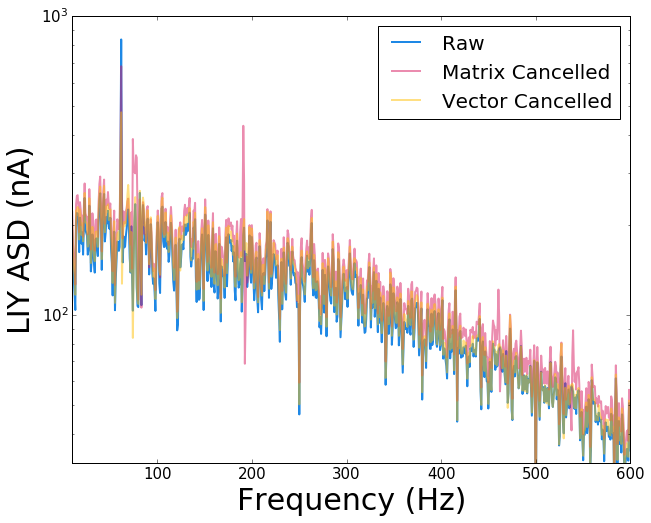

In [66]:

# liy_calc_fft = fft.fft(1e9*cur_filt[:100000])
# liy_mat_fft = fft.fft(1e9*mat_filt[:100000])
# liy_vec_fft = fft.fft(1e9*vec_filt[:100000])
liy_calc_fft = np.zeros(len(cur_cut[:swp_pnt[0]-2580]),dtype='complex128')
liy_mat_fft = np.zeros(len(cur_cut[:swp_pnt[0]-2580]),dtype='complex128')
liy_vec_fft = np.zeros(len(cur_cut[:swp_pnt[0]-2580]),dtype='complex128')
freqs = fft.fftfreq(len(liy_mat_fft),1/10000)
prev = 0
for pnt in swp_pnt[:499]:
    x = (pnt-prev) -len(liy_calc_fft)
    liy_calc_fft = liy_calc_fft + fft.fft(1e9*cur_filt[prev:pnt-x])
    liy_mat_fft = liy_mat_fft + fft.fft(1e9*mat_filt[prev:pnt-x])
    liy_vec_fft = liy_vec_fft + fft.fft(1e9*vec_filt[prev:pnt-x])
liy_calc_fft = liy_calc_fft/499
liy_mat_fft = liy_mat_fft/499
liy_vec_fft = liy_vec_fft/499

# freqs = fft.fftfreq(len(liy_calc_fft),1/10000)
# print(np.where(abs(freqs-62)<1),print(absolute(liy_calc_fft[75:77])**2))
semilogy(freqs[:int(len(freqs)/2)],
         absolute(liy_calc_fft[:int(len(freqs)/2)])**2,
         '#1e88e5',label='Raw',linewidth=2)
semilogy(freqs[:int(len(freqs)/2)],
         absolute(liy_mat_fft[:int(len(freqs)/2)])**2,
         '#d81b60',label='Matrix Cancelled',linewidth=2,alpha=0.5)
semilogy(freqs[:int(len(freqs)/2)],
         absolute(liy_vec_fft[:int(len(freqs)/2)])**2,
         '#ffc107',label='Vector Cancelled',linewidth=2,alpha=0.5)
xlim(10,600)
ylim(3.2e1,1e3)
legend(loc=0,fontsize=20)
tick_params(labelsize=15)
xlabel('Frequency (Hz)',size=30)
ylabel('LIY ASD (nA)',size=30)
# savefig('2020-4-10 LIY freq map',transparent=True)

In [ ]:
print(1-absolute(liy_mat_fft[75]/liy_calc_fft[75]))
print(1-absolute(liy_vec_fft[75]/liy_calc_fft[75]))

In [ ]:
rms_cur = np.zeros(int(len(cur_filt)//10000))
rms_mat = np.zeros(int(len(cur_filt)//10000))
rms_vec = np.zeros(int(len(cur_filt)//10000))
prev = 0
for i in arange(len(rms_cur)):
    end = (i+1)*10000
    rms_cur[i] = sqrt(mean((cur_filt[prev:end]-mean(cur_filt[prev:end]))**2))
    rms_mat[i] = sqrt(mean((mat_filt[prev:end]-mean(mat_filt[prev:end]))**2))
    rms_vec[i] = sqrt(mean((vec_filt[prev:end]-mean(vec_filt[prev:end]))**2))
    prev = end
print('RMS LIY:',mean(rms_cur))
print('STD LIY:',std(rms_cur))
print('RMS mat:',mean(rms_mat))
print('STD mat:',std(rms_mat))
print('RMS vec:',mean(rms_vec))
print('STD vec:',std(rms_vec))
print('Mat cancellation:',100-100*mean(rms_mat)/mean(rms_cur))
print('Mat std cancellation:',100-100*std(rms_mat)/std(rms_cur))
print('Vec cancellation:',100-100*mean(rms_vec)/mean(rms_cur))
print('Mat cancellation:',100-100*std(rms_vec)/std(rms_cur))